In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

from typing import List, Set, Dict, Tuple, Optional, Any
from collections import defaultdict

import pandas as pd
import seaborn as sns
import numpy as np

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution, Normal
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix

from gmfpp.utils.data_preparation import *
from gmfpp.utils.data_transformers import *
from gmfpp.utils.plotting import *
from gmfpp.utils.training import *

from gmfpp.models.ReparameterizedDiagonalGaussian import *
from gmfpp.models.CytoVariationalAutoencoder import *
from gmfpp.models.VariationalAutoencoder import *
from gmfpp.models.ConvVariationalAutoencoder import *
from gmfpp.models.VariationalInference_nonvar import *
from gmfpp.models.LoadModels import *


In [7]:
constant_seed()
datetime = get_datetime()
output_folder = "dump/outputs_{}/".format(datetime)
create_directory(output_folder)
logfile = create_logfile(output_folder + "log.log")


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cprint(f"Using device: {device}", logfile)

15:27:29 | Using device: cpu


In [10]:

#path = get_server_directory_path()
path = "data/all/"

metadata = read_metadata(path + "metadata.csv")
metadata = metadata[:2]
cprint("loaded metadata",logfile)

cprint("loading images", logfile)
relative_paths = get_relative_image_paths(metadata)
image_paths = [path + relative for relative in relative_paths]
images = load_images(image_paths, verbose=True, log_every=10000, logfile=logfile)
#images = torch.load("dump/all_data.pt")
mapping = get_MOA_mappings(metadata)
cprint("loaded images", logfile)
normalize_every_image_channels_seperately_inplace(images)
cprint("normalized images", logfile)

metadata = shuffle_metadata(metadata)
metadata_train, metadata_validation = split_metadata(metadata, split_fraction = .90)
#metadata_train, metadata_validation = metadata, metadata


15:27:58 | loaded metadata
15:27:58 | loading images
15:27:58 | loaded 0/2 images (0.00%).
15:27:58 | loaded 2/2 images (100.00%).
15:27:58 | loaded images
15:27:58 | normalized images


In [11]:
train_set = SingleCellDataset(metadata_train, images, mapping)
validation_set = SingleCellDataset(metadata_validation, images, mapping)

In [12]:
def initVAEmodel(latent_features= 256,
                    beta = 1.,
                    num_epochs = 1000,
                    batch_size = 32,
                    learning_rate = 1e-3,
                    weight_decay = 10e-4,
                    image_shape = np.array([3, 68, 68]),
                    model_type = "Cyto"):

    VAE_settings = {
        'latent_features' : latent_features,
        'beta' : beta,
        'num_epochs' : num_epochs,
        'batch_size' : batch_size,
        'learning_rate' : learning_rate,
        'weight_decay' : weight_decay,
        'image_shape' : image_shape,
        'model_type' : model_type
        }
        
    training_performance = defaultdict(list)
    validation_performance = defaultdict(list)

    if (model_type == None) or model_type == "Cyto":
        vae = CytoVariationalAutoencoder(VAE_settings['image_shape'], VAE_settings['latent_features'])
    if model_type == 'Cyto_nonvar':
        vae = CytoVariationalAutoencoder_nonvar(VAE_settings['image_shape'], VAE_settings['latent_features'])
    if model_type == 'basic':
        vae = VariationalAutoencoder(VAE_settings['image_shape'], VAE_settings['latent_features'])
    if model_type == 'Conv_simon':
        vae = ConvVariationalAutoencoder(VAE_settings['image_shape'], VAE_settings['latent_features'])
    if model_type == 'SparseVAE':
        vae = SparseVariationalAutoencoder(VAE_settings['image_shape'], VAE_settings['latent_features'])
    
    return vae, validation_performance, training_performance, VAE_settings

In [67]:
class SparseVariationalAutoencoder(nn.Module):
   
    def __init__(self, input_shape, latent_features: int) -> None:
        super(SparseVariationalAutoencoder, self).__init__()
        #print("Init SVAE input_shape, latent_features: ", input_shape, latent_features)
        self.input_shape = getattr(input_shape, "tolist", lambda: input_shape)()
        #print("Init SVAE self.input_shape: ", tuple(self.input_shape))
        
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self.observation_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=3*latent_features)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=1*self.observation_features),
            nn.Unflatten(1,self.input_shape)
        )
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        #print("Init SVAE end")

    def observation(self, z:Tensor) -> Tensor:
        """return the distribution `p(x|z)`"""
        mu = self.decoder(z)
        mu = mu.view(-1, *self.input_shape) # reshape the output
        return mu
    def ReparameterizedSpikeAndSlab_sample(mu, log_sigma, log_gamma):
        eps = torch.empty_like(log_sigma.exp()).normal_()
        eta = torch.empty_like(log_sigma.exp()).normal_()
        selector = nn.functional.sigmoid(log_gamma.exp() + eta -1)    
        return selector * (mu + eps.mul(log_sigma.exp()))
    
    def forward(self, x) -> Dict[str, Any]:
        # flatten the input
        #x = x.reshape(x.size(0), -1)
        h_z = self.encoder(x)
        qz_mu, qz_log_sigma, qz_log_gamma = h_z.chunk(3, dim=-1)

        #print("mu.shape", mu.shape) # should be dim batch, x, y, channel
        #print("log_sigma.shape", log_sigma.shape) # should be dim batch, x, y, channel
        #print("log_gamma.shape", log_gamma.shape) # should be dim batch, x, y, channel, #latentvar
        z = ReparameterizedSpikeAndSlab_sample(qz_mu, qz_log_sigma, qz_log_gamma)
        x_hat = self.observation(z)
        #print("x_hat.shape", x_hat.shape) 
        
        return {'x_hat': x_hat, 
                'z': z, 
                'qz_log_gamma': qz_log_gamma, 
                'qz_mu': qz_mu, 
                'qz_log_sigma':qz_log_sigma}
    

In [366]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    flat = view_flat_samples(x)
    return flat.sum(dim=1)

class VariationalInference_SparseVAE(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        self.alpha = torch.Tensor([0.5])
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        outputs = model(x)

        x_hat, z, qz_log_gamma, qz_mu, qz_log_sigma = [outputs[k] for k in ['x_hat', 'z', 'qz_log_gamma', 'qz_mu', 'qz_log_sigma']]
        
        # My implementation
        #qz_gamma = qz_log_gamma.exp()
        #qz_gamma = torch.clamp(qz_log_gamma.exp(), 1e-6, 1.0 - 1e-6) 
        #KL_part1 = qz_gamma.mul(1 + qz_log_sigma * 2 - qz_mu ** 2 - qz_log_sigma.exp() ** 2)/2
        #KL_part2 = -(1 - qz_gamma).mul(((1 - self.alpha).div(1 - qz_gamma)).log())
        #KL_part3 = -qz_gamma.mul((self.alpha.div(qz_gamma)).log())
        
        # implementation from github
        qz_gamma = torch.clamp(qz_log_gamma.exp(), 1e-6, 1.0 - 1e-6) 
        KL_part1 = 0.5 * qz_gamma.mul(1 + qz_log_sigma * 2 - qz_mu ** 2 - qz_log_sigma.exp() ** 2)
        KL_part2 = (1 - qz_gamma).mul(((1 - self.alpha)/(1 - qz_gamma)).log())
        KL_part3 = qz_gamma.mul((self.alpha/qz_gamma).log())
    
    
#        meh = torch.log((1 - qz_gamma)/(1 - self.alpha))
#        meh2 = 1 - qz_gamma
#        print("torch.log((1 - qz_gamma)/(1 - self.alpha) number of nans", meh.isnan().sum(axis=[1]))
#        print("(1 - qz_gamma) number of nans", meh2.isnan().sum(axis=[1]))
#        print("KL_part1 number of nans", KL_part1.isnan().sum(axis=[1]))
#        print("KL_part2 number of nans", KL_part2.isnan().sum(axis=[1]))
#        print("KL_part3 number of nans", KL_part3.isnan().sum(axis=[1]))
#        print("qz_gamma number of nans", qz_gamma.isnan().sum(axis=[1]))
        
#        print("(1 - qz_gamma)/(1 - self.alpha))==0 number of: ", (((1 - qz_gamma)/(1 - self.alpha))==0).sum(axis=[1]))
#        print("qz_gamma", qz_gamma)
        KL = -(KL_part1 + KL_part2 + KL_part3).sum(axis=[1])
#        print("KL", KL)
#        print("KL.shape", KL.shape)
        
        mse_loss = ((x_hat - x)**2).sum(axis=[1,2,3])
#        print("mse_loss.shape", mse_loss.shape)

        beta_elbo = -self.beta * KL - mse_loss

        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': beta_elbo, 'mse_loss':mse_loss, 'kl': KL, 'loss': loss}
            
        return loss, diagnostics, outputs

In [367]:
vae, validation_data, training_data, VAE_settings = initVAEmodel(latent_features= 256,
                                                                    beta = 1.0,
                                                                    num_epochs = 1000,
                                                                    batch_size = min(64, len(train_set)),
                                                                    learning_rate = 1e-3,
                                                                    weight_decay = 1e-3,
                                                                    image_shape = np.array([3, 68, 68]),
                                                                    model_type = "SparseVAE"
                                                                    )

In [368]:
vae = vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=VAE_settings['learning_rate'], weight_decay=VAE_settings['weight_decay'])

vi = VariationalInference_SparseVAE(beta=VAE_settings['beta'])

In [369]:
train_loader = DataLoader(train_set, batch_size=VAE_settings['batch_size'], shuffle=True, num_workers=0, drop_last=True)
validation_loader = DataLoader(validation_set, batch_size=VAE_settings['batch_size'], shuffle=False, num_workers=0, drop_last=False)


In [370]:
######### VAE Training #########
cprint("VAE Training", logfile)

num_epochs = VAE_settings['num_epochs']
batch_size = VAE_settings['batch_size']

print_every = 100
impatience_level = 0
max_patience = 100

best_elbo = np.finfo(np.float64).min

10:36:26 | VAE Training


In [371]:
for epoch in range(num_epochs):
    if epoch % print_every == 0:
        cprint(f"\n\nepoch START: {epoch}/{num_epochs}", logfile)

    training_epoch_data = defaultdict(list)
    vae.train()
    
    for x, _ in train_loader:
        x = x.to(device)
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(vae.parameters(), 10_000)
        optimizer.step()
        
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
    
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]
    
    with torch.no_grad():
        vae.eval()
        
        validation_epoch_data = defaultdict(list)
        
        for x, _ in validation_loader:
            x = x.to(device)
            
            loss, diagnostics, outputs = vi(vae, x)
            
            for k, v in diagnostics.items():
                validation_epoch_data[k] += [v.mean().item()]
        
        for k, v in diagnostics.items():
            validation_data[k] += [np.mean(validation_epoch_data[k])]
        
        impatience_level += 1
        
        current_elbo = validation_data["elbo"][-1]

        if epoch % print_every == 0:
            cprint(f"epoch: {epoch}/{num_epochs}", logfile)
            train_string = StatusString("training", training_epoch_data)
            evalString = StatusString("evaluation", validation_data)
            cprint(train_string, logfile)
            cprint(evalString, logfile)



10:36:26 | 

epoch START: 0/1000
10:36:26 | epoch: 0/1000
10:36:26 | training 	| elbo: -3635.8994, 	mse_loss: 3486.9224, 	kl: 148.9772, 	loss: 3635.8994, 	
10:36:26 | evaluation 	| elbo: nan, 	mse_loss: nan, 	kl: nan, 	loss: nan, 	
10:36:28 | 

epoch START: 100/1000
10:36:28 | epoch: 100/1000
10:36:28 | training 	| elbo: -322.1900, 	mse_loss: 285.1215, 	kl: 37.0685, 	loss: 322.1900, 	
10:36:28 | evaluation 	| elbo: nan, 	mse_loss: nan, 	kl: nan, 	loss: nan, 	
10:36:30 | 

epoch START: 200/1000
10:36:30 | epoch: 200/1000
10:36:30 | training 	| elbo: -128.7908, 	mse_loss: 103.1486, 	kl: 25.6421, 	loss: 128.7908, 	
10:36:30 | evaluation 	| elbo: nan, 	mse_loss: nan, 	kl: nan, 	loss: nan, 	
10:36:32 | 

epoch START: 300/1000
10:36:32 | epoch: 300/1000
10:36:32 | training 	| elbo: -58.7887, 	mse_loss: 41.0289, 	kl: 17.7598, 	loss: 58.7887, 	
10:36:32 | evaluation 	| elbo: nan, 	mse_loss: nan, 	kl: nan, 	loss: nan, 	
10:36:34 | 

epoch START: 400/1000
10:36:35 | epoch: 400/1000
10:36:35 | tr

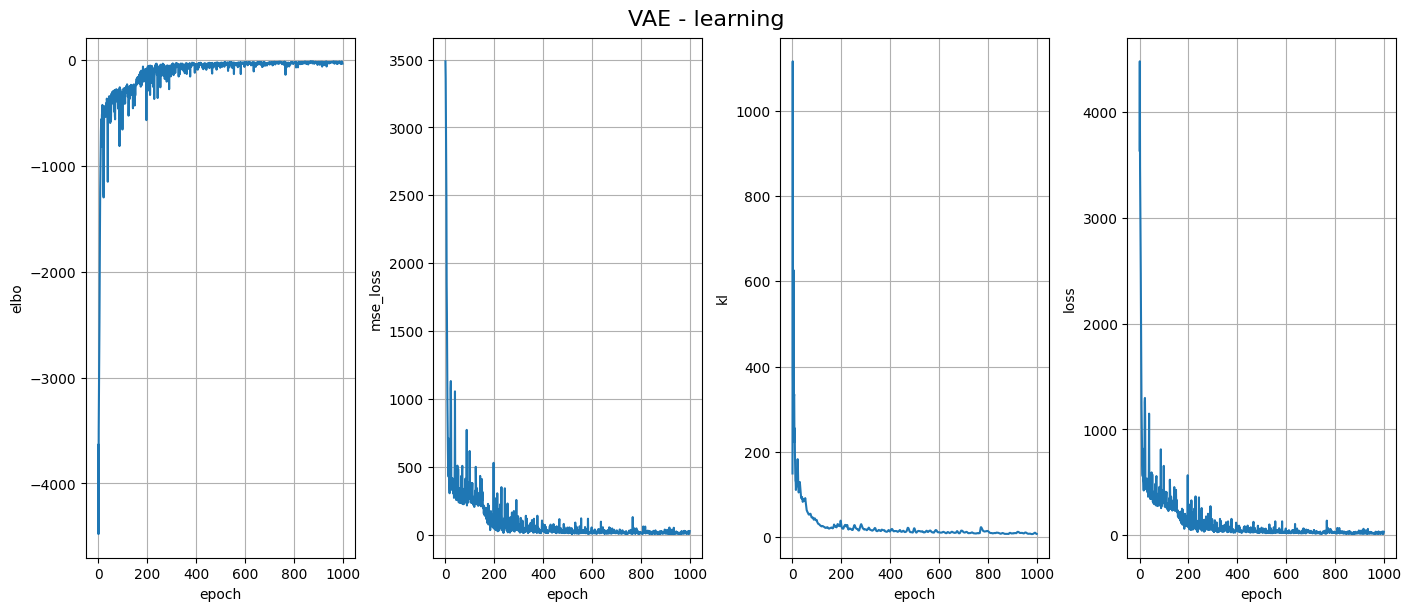

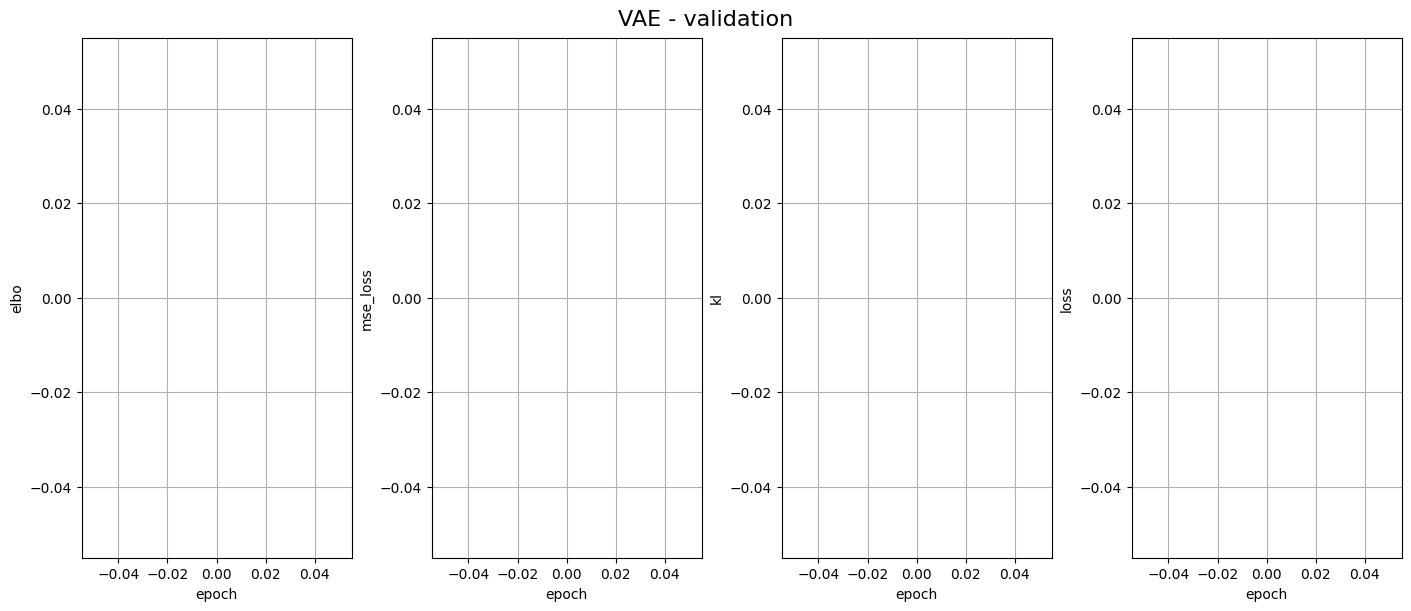

In [372]:
plot_VAE_performance(training_data, title='VAE - learning')
plot_VAE_performance(validation_data, title='VAE - validation')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2d704ace-07ad-46d7-b65e-50921c60f0ae' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>